In [10]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Import play-by-play data for the 2016-2022 seasons
seasons = range(2016, 2023)
pbp = nfl.import_pbp_data(seasons)

sns.set_theme(style='whitegrid', palette='colorblind')

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [33]:
pbp_run = pbp[pbp['play_type'] == 'run']
pbp_run = pbp_run.dropna(subset=['rusher_id'])
pbp_run = pbp_run.dropna(subset=['down'])
pbp_run.loc[pbp_run['rushing_yards'].isnull(), 'rushing_yards'] = 0
pbp_run.shape

(92176, 391)

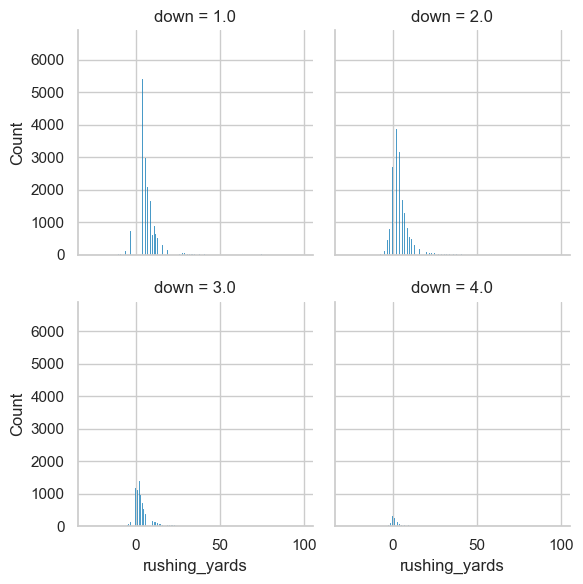

In [35]:
g = sns.FacetGrid(data=pbp_run, col='down', col_wrap=2)
g.map_dataframe(sns.histplot, x='rushing_yards')
plt.show()

<Axes: xlabel='down', ylabel='rushing_yards'>

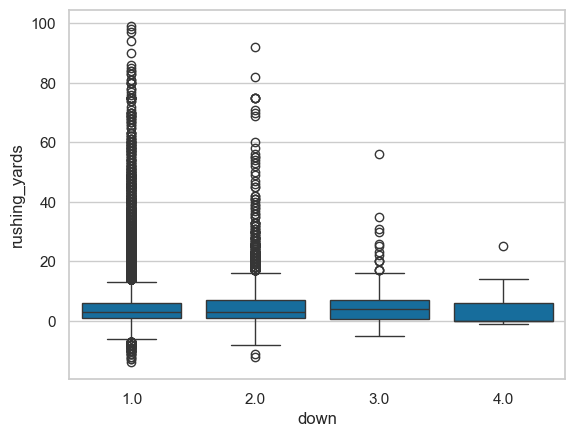

In [37]:
sns.boxplot(data=pbp_run[pbp_run['ydstogo'] == 10], x='down', y='rushing_yards')

<Axes: xlabel='yardline_100', ylabel='rushing_yards'>

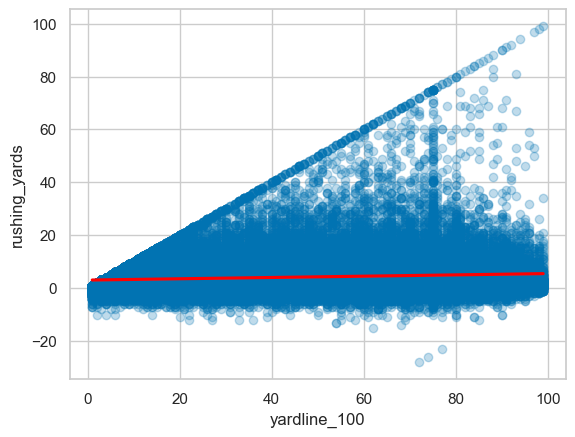

In [38]:
sns.regplot(
    data=pbp_run,
    x='yardline_100',
    y='rushing_yards',
    scatter_kws={'alpha': 0.25},
    line_kws={'color': 'red'}
)

In [60]:
pbp_run_y100 = pbp_run \
    .groupby('yardline_100') \
    .agg({'rushing_yards': ['mean']})
pbp_run_y100.columns = list(map('_'.join, pbp_run_y100.columns))
pbp_run_y100 = pbp_run_y100.reset_index()

<Axes: xlabel='yardline_100', ylabel='rushing_yards_mean'>

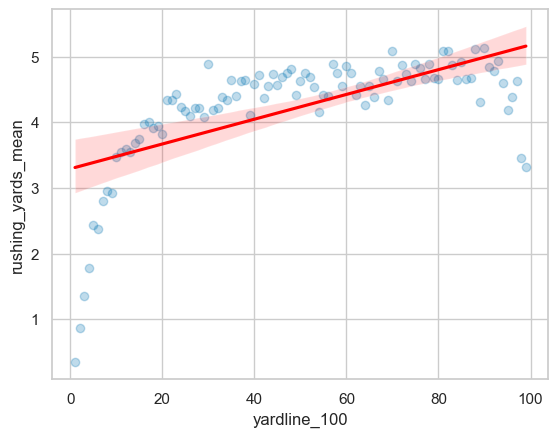

In [62]:
sns.regplot(
    data=pbp_run_y100,
    x='yardline_100',
    y='rushing_yards_mean',
    scatter_kws={'alpha': 0.25},
    line_kws={'color': 'red'}
)

<Axes: xlabel='run_location', ylabel='rushing_yards'>

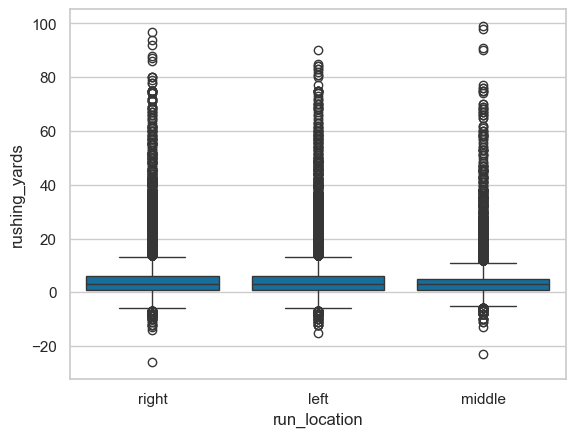

In [63]:
sns.boxplot(data=pbp_run, x='run_location', y='rushing_yards')

In [64]:
pbp_run_sd = pbp_run \
    .groupby('score_differential') \
    .agg({'rushing_yards': ['mean']})

pbp_run_sd.columns = list(map('_'.join, pbp_run_sd.columns))
pbp_run_sd = pbp_run_sd.reset_index()

<Axes: xlabel='score_differential', ylabel='rushing_yards_mean'>

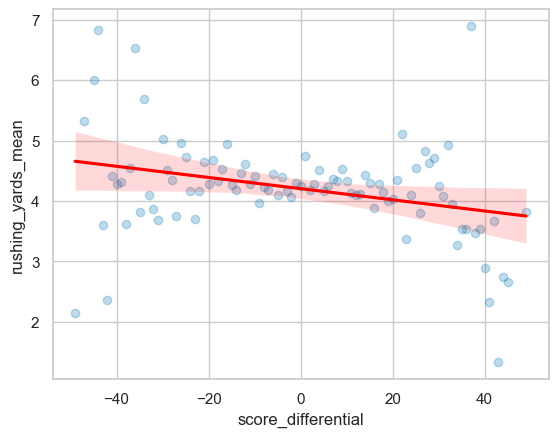

In [65]:
sns.regplot(
    data=pbp_run_sd,
    x='score_differential',
    y='rushing_yards_mean',
    scatter_kws={'alpha': 0.25},
    line_kws={'color': 'red'}
)

In [72]:
pbp_run['down'] = pbp_run['down'].astype(str)

formula = 'rushing_yards ~ 1 + down + ydstogo + down:ydstogo + yardline_100 + run_location + score_differential'
expected_yards = smf.ols(
    formula=formula,
    data=pbp_run
).fit()
pbp_run['ryoe'] = expected_yards.resid
expected_yards.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          rushing_yards   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     136.6
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          3.30e-313
Time:                        12:53:49   Log-Likelihood:            -2.9758e+05
No. Observations:               91425   AIC:                         5.952e+05
Df Residuals:                   91413   BIC:                         5.953e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.6085      0.136     11.848      0.000       1.342       1.875
down[T.2.0]                1.6146      0.153     10.572      0.000       1.315       1.914
down[T.3.0]                1.2845      0.161      7.989      0.000       0.969       1.600
down[T.4.0]                0.2849      0.249      1.144      0.253      -0.203       0.773
run_location[T.middle]    -0.5646      0.053    -10.741      0.000      -0.668      -0.462
run_location[T.right]     -0.0381      0.049     -0.782      0.434      -0.134       0.057
ydstogo                    0.2023      0.014     14.436      0.000       0.175       0.230
down[T.2.0]:ydstogo       -0.1466      0.016     -8.955      0.000      -0.179      -0.114
down[T.3.0]:ydstogo       -0.0439      0.019     -2.335      0.020      -0.081      -0.007
down[T.4.0]:ydstogo        0.2302      0.090      2.566      0.010       0.054       0.406
yardline_100               0.0186      0.001     21.233      0.000       0.017       0.020
score_differential        -0.0040      0.002     -2.021      0.043      -0.008      -0.000
==============================================================================
Omnibus:                    80505.699   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3942238.433
Skew:                           4.083   Prob(JB):                         0.00
Kurtosis:                      34.116   Cond. No.                         838.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
ryoe = pbp_run \
    .groupby(['season', 'rusher_id', 'rusher']) \
    .agg({
        'ryoe': ['mean', 'sum', 'count'],
        'rushing_yards': ['mean']
    })

ryoe.columns = list(map('_'.join, ryoe.columns))
ryoe = ryoe.reset_index()

ryoe.rename(
    columns={
        'ryoe_count':'n',
        'ryoe_sum': 'ryoe_total',
        'ryoe_mean': 'ryoe_per',
        'rushing_yards_mean': 'yards_per_carry'
    }, 
    inplace=True
)

ryoe = ryoe[ryoe['n'] >= 50]

ryoe.sort_values("ryoe_total", ascending=False).head(10)

,season,rusher_id,rusher,ryoe_per,ryoe_total,n,yards_per_carry
1981,2021,00-0036223,J.Taylor,1.420040,471.453295,332,5.454819
1433,2020,00-0032764,D.Henry,0.876202,346.099772,395,5.232912
1252,2019,00-0034796,L.Jackson,2.607735,328.574640,126,6.902256
1138,2019,00-0032764,D.Henry,0.807804,311.812329,386,5.145078
1467,2020,00-0033293,A.Jones,1.366009,301.888039,221,5.565611
2227,2022,00-0034796,L.Jackson,3.899849,280.789094,72,7.821918
1097,2019,00-0031687,R.Mostert,1.442940,274.158584,190,5.831579
317,2016,00-0033045,E.Elliott,0.800300,273.702551,342,5.104651
1553,2020,00-0034796,L.Jackson,2.187485,258.123267,118,6.264463
1893,2021,00-0034791,N.Chubb,1.088484,248.174451,228,5.521930


In [82]:
ryoe.sort_values("ryoe_per", ascending=False).head(10)

,season,rusher_id,rusher,ryoe_per,ryoe_total,n,yards_per_carry
2227,2022,00-0034796,L.Jackson,3.899849,280.789094,72,7.821918
1280,2019,00-0035228,K.Murray,2.622655,136.378062,52,6.527273
1252,2019,00-0034796,L.Jackson,2.607735,328.574640,126,6.902256
2368,2022,00-0036945,J.Fields,2.304412,177.439734,77,6.000000
1553,2020,00-0034796,L.Jackson,2.187485,258.123267,118,6.264463
375,2017,00-0027939,C.Newton,2.079406,191.305336,92,5.816327
1587,2020,00-0035228,K.Murray,2.056120,143.928395,70,5.635135
1890,2021,00-0034750,R.Penny,2.030779,241.662644,119,6.294117
1230,2019,00-0034400,J.Wilkins,1.917437,97.789267,51,6.019608
2157,2022,00-0033357,T.Hill,1.802622,171.249083,95,5.989583


In [86]:
cols = ['season', 'rusher_id', 'rusher', 'ryoe_per', 'yards_per_carry']
ryoe_now = ryoe[cols].copy()
ryoe_last = ryoe[cols].copy()
ryoe_last.rename(columns={'ryoe_per': 'ryoe_per_last', 'yards_per_carry': 'yards_per_carry_last'}, inplace=True)
ryoe_now['season'] = ryoe_now['season'] + 1
ryoe_lag = ryoe_now.merge(ryoe_last, on=['season', 'rusher_id', 'rusher'], how='inner')

In [85]:
ryoe_lag[['yards_per_carry_last', 'yards_per_carry']].corr()

,yards_per_carry_last,yards_per_carry
yards_per_carry_last,1.000000,0.330571
yards_per_carry,0.330571,1.000000


In [87]:
ryoe_lag[['ryoe_per_last', 'ryoe_per']].corr()

,ryoe_per_last,ryoe_per
ryoe_per_last,1.000000,0.374353
ryoe_per,0.374353,1.000000
